### Figure 3 - Data analysis

**Author:** Quentin Duez

This notebook analyses ESI-MS data and extracts relative time delays and amplitudes of propagating perturbations.

**Outputs:** Figure 3C, D, F and Figure S4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.metrics import r2_score

sns.set_theme(style="ticks", context="paper")

TIMEBIN = 15  # ~1bin = 30s
Ald_conc = 5  # mM
Cat_conc = 2  # mM
Cyclo_conc = 250  # mM

In [2]:
# Fitting functions


def sinfunc(t, A, w, p, c):
    return A * np.sin(np.pi * (t - p) / w) + c
    # return A * np.sin(w*t + p) + c


def fit_sin(
    tt, yy, PERIOD
):  # Scooped from https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    # guess_freq = 1./ PERIOD
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array(
        [guess_amp, PERIOD / 2, 0.0, guess_offset]
    )  # Guess phase = 0; check what works better

    popt, pcov = curve_fit(
        sinfunc,
        tt,
        yy,
        p0=guess,
        bounds=(
            (0, (PERIOD - 0.0001) / 2, -np.inf, -np.inf),
            (np.inf, (PERIOD + 0.0001) / 2, np.inf, np.inf),
        ),
    )
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    period = w * 2
    fitfunc = lambda t: A * np.sin(np.pi * (t - p) / w) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": period,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }


def fit_sin_CSTR(t, conc, eq_time, PERIOD):
    t_filtered = t[eq_time:]
    conc_filtered = conc[eq_time:]

    res = fit_sin(t_filtered, conc_filtered, PERIOD)
    ypred = sinfunc(t_filtered, res["amp"], res["omega"], res["phase"], res["offset"])
    r2 = r2_score(conc_filtered, ypred)
    # print(r2_score(conc_filtered, ypred))
    phase = res["phase"]
    amp = res["amp"]

    if abs(phase) > PERIOD:
        ntot = abs(phase) / PERIOD
        nunits = ntot // 1
        if nunits > 0:
            coma = ntot - nunits
        else:
            coma = 0
        phase = coma * PERIOD
    else:
        phase = phase

    if r2 > 0.2:  # Condition for not trying to interpret weird data
        rel_amp = (
            abs(res["amp"]) / res["offset"]
        )  # Calculate the amplitude of the oscillation relative to the ion signal

        # Get time delay from the phase (empirically determined, was tricky for me brain)
        if (res["amp"] > 0) & (phase > 0):
            delay = phase + 0.5 * res["omega"]
        elif (res["amp"] > 0) & (phase < 0):
            delay = phase + 2.5 * res["omega"]
        else:
            pass
    else:
        rel_amp = 0
        delay = 0
        phase = 0

    return (rel_amp, delay, r2, phase, amp)

In [3]:
# Reading flow profile
profile = pd.read_excel("data/Iminium16.xlsx")
profile = profile.iloc[
    :, : profile.columns.get_loc("Concentration")
]  # Dropping everything after "Concentration"
profile = profile.iloc[
    :, profile.columns.get_loc("Flow") + 1 :
]  # Dropping everything before "Flow"
profile = profile.drop(columns=["Time"])
profile.set_index("Cumul. Time", inplace=True)
profile["Aldehyde_conc"] = (profile["Aldehyde"] * Ald_conc) / profile.sum(axis=1)
profile["Aldehyde_conc_rel"] = (
    profile["Aldehyde_conc"] / profile["Aldehyde_conc"].mean()
)
profile = profile.dropna()

profile.index = profile.index - 540

print(profile)

             Aldehyde     Cat     MeOH1     MeOH2     MeOH3  Aldehyde_conc  \
Cumul. Time                                                                  
-540.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
-390.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
-389.9       5.826987  5.7666  5.746582  5.746582  5.746582       1.010460   
-389.8       5.887367  5.7666  5.726456  5.726456  5.726456       1.020931   
-389.7       5.947733  5.7666  5.706333  5.706333  5.706333       1.031399   
...               ...     ...       ...       ...       ...            ...   
 779.8       5.706213  5.7666  5.786840  5.786840  5.786840       0.989517   
 779.9       5.736406  5.7666  5.776776  5.776776  5.776776       0.994753   
 780.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
 870.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
-540.0       5.766600  5.7666  5.766711  5.766711  5.766711     

In [4]:
# Reading data
data = pd.read_excel("data/Iminium16_Data.xlsx", header=0)

data["155_TIC"] = data["IC_155"] / data["TIC"]
data["326_TIC"] = (
    data["IC_326"] / data["TIC"]
)  # 326 was saturating a bit, we will not use it
data["440_TIC"] = data["IC_440"] / data["TIC"]
data["506_TIC"] = data["IC_506"] / data["TIC"]
data["651_TIC"] = (
    data["IC_651"] / data["TIC"]
)  # 651 could be the product (although super low intensity)

bindata = data.groupby(data.index // TIMEBIN).mean()
bindata = bindata.drop(columns=["TIC"])
bindata.set_index("Time", inplace=True)

rolled_bindata = bindata.rolling(5, center=True).mean()

print(bindata)

                   IC_155        IC_326        IC_440        IC_506  \
Time                                                                  
0.401400     3.833819e+07  3.199667e+09  2.262946e+08  6.319223e+06   
1.154400     3.812484e+07  3.224543e+09  2.555616e+08  6.866176e+06   
1.907400     3.781840e+07  3.169338e+09  2.869572e+08  8.280030e+06   
2.660400     3.983749e+07  3.179133e+09  3.075240e+08  8.370189e+06   
3.413400     3.915190e+07  3.208304e+09  3.100168e+08  8.910450e+06   
...                   ...           ...           ...           ...   
1407.758400  3.168133e+07  1.490419e+09  4.565290e+08  1.856964e+08   
1408.511400  3.170908e+07  1.551939e+09  4.335141e+08  1.945139e+08   
1409.264400  3.252482e+07  1.515552e+09  4.212386e+08  1.937332e+08   
1410.017400  3.111967e+07  1.586625e+09  4.201246e+08  2.040018e+08   
1410.720154  2.969619e+07  1.598227e+09  4.318284e+08  1.873929e+08   

                   IC_651   155_TIC   326_TIC   440_TIC   506_TIC   651_TIC 

In [5]:
data_2ndosci = bindata[(bindata.index > 540) & (bindata.index < 1410)]
data_2ndosci["155_TIC_rel"] = data_2ndosci["155_TIC"] / data_2ndosci["155_TIC"].mean()
data_2ndosci["326_TIC_rel"] = data_2ndosci["326_TIC"] / data_2ndosci["326_TIC"].mean()
data_2ndosci["440_TIC_rel"] = data_2ndosci["440_TIC"] / data_2ndosci["440_TIC"].mean()
data_2ndosci["506_TIC_rel"] = data_2ndosci["506_TIC"] / data_2ndosci["506_TIC"].mean()
data_2ndosci["651_TIC_rel"] = data_2ndosci["651_TIC"] / data_2ndosci["651_TIC"].mean()
rolled_data_2ndosci = data_2ndosci.rolling(5, center=True).mean()
rolled_data_2ndosci = rolled_data_2ndosci.dropna()

data_2ndosci.index = data_2ndosci.index - 540
rolled_data_2ndosci.index = rolled_data_2ndosci.index - 540
profile_2ndosci = profile[(profile.index > 0) & (profile.index < 900)]

C:\Users\qduez\AppData\Local\Temp\ipykernel_27328\3867290118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2ndosci["155_TIC_rel"] = data_2ndosci["155_TIC"] / data_2ndosci["155_TIC"].mean()
C:\Users\qduez\AppData\Local\Temp\ipykernel_27328\3867290118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2ndosci["326_TIC_rel"] = data_2ndosci["326_TIC"] / data_2ndosci["326_TIC"].mean()
C:\Users\qduez\AppData\Local\Temp\ipykernel_27328\3867290118.py:4: SettingWithCopyWarning: 
A value is trying to

155 (0.17072209099817529, 110.5669799528764, 0.5137347028573087)
440 (0.3883685058916292, 113.42863458523819, 0.6743657597639338)
506 (0.27369784252822205, 134.00720248052963, 0.6497656244843097)
651 (0.16051074870951887, 55.15845415325933, 0.7810659871784389)


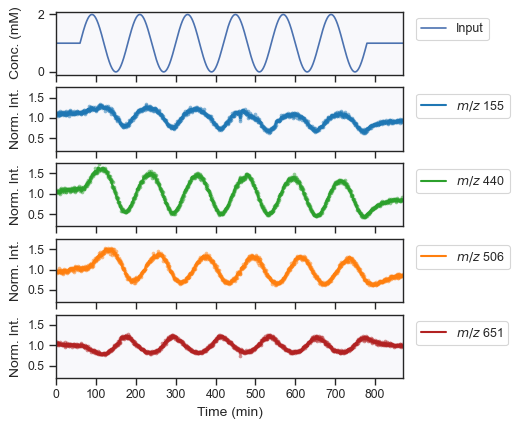

In [6]:
fig, ax = plt.subplots(5, 1, figsize=(7.3, 3.7))

sns.lineplot(
    data=profile, x=profile.index, y="Aldehyde_conc_rel", ax=ax[0], label="Input"
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="155_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[1],
    c="tab:blue",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="155_TIC_rel",
    ax=ax[1],
    linewidth=1.5,
    label=r"$\it{m/z}$ 155",
    c="tab:blue",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="440_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[2],
    c="tab:green",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="440_TIC_rel",
    ax=ax[2],
    linewidth=1.5,
    label=r"$\it{m/z}$ 440",
    c="tab:green",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="506_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[3],
    c="tab:orange",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="506_TIC_rel",
    ax=ax[3],
    linewidth=1.5,
    label=r"$\it{m/z}$ 506",
    c="tab:orange",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="651_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[4],
    c="firebrick",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="651_TIC_rel",
    ax=ax[4],
    linewidth=1.5,
    label=r"$\it{m/z}$ 651",
    c="firebrick",
)

ax[0].set_xlim(0, 870)
ax[1].set_xlim(0, 870)
ax[2].set_xlim(0, 870)
ax[3].set_xlim(0, 870)
ax[4].set_xlim(0, 870)
ax[1].set_ylim(0.2, 1.75)
ax[2].set_ylim(0.2, 1.75)
ax[3].set_ylim(0.2, 1.75)
ax[4].set_ylim(0.2, 1.75)

ax[0].set_ylabel("Conc. (mM)", fontsize=10)
ax[1].set_ylabel("Norm. Int.", fontsize=10)
ax[2].set_ylabel("Norm. Int.", fontsize=10)
ax[3].set_ylabel("Norm. Int.", fontsize=10)
ax[4].set_ylabel("Norm. Int.", fontsize=10)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[3].set_xlabel("")
ax[4].set_xlabel("Time (min)", fontsize=10)

ax[0].set_xticklabels("")
ax[1].set_xticklabels("")
ax[2].set_xticklabels("")
ax[3].set_xticklabels("")


fit_155 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["155_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_440 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["440_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_506 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["506_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_651 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["651_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time

pred_155 = sinfunc(data_2ndosci.index.to_numpy(), fit_155[4], 60, fit_155[3], 1)
pred_440 = sinfunc(data_2ndosci.index.to_numpy(), fit_440[4], 60, fit_440[3], 1)
pred_506 = sinfunc(data_2ndosci.index.to_numpy(), fit_506[4], 60, fit_506[3], 1)
pred_651 = sinfunc(data_2ndosci.index.to_numpy(), fit_651[4], 60, fit_651[3], 1)

# Uncomment to plot the fitted sinewaves
# sns.lineplot(x=data_2ndosci.index.to_numpy(), y=pred_155, ax=ax[1], linewidth=1.5, label="fit", c='tab:purple')
# sns.lineplot(x=data_2ndosci.index.to_numpy(), y=pred_440, ax=ax[2], linewidth=1.5, label="fit", c='tab:purple')
# sns.lineplot(x=data_2ndosci.index.to_numpy(), y=pred_506, ax=ax[3], linewidth=1.5, label="fit", c='tab:purple')
# sns.lineplot(x=data_2ndosci.index.to_numpy(), y=pred_651, ax=ax[4], linewidth=1.5, label="fit", c='tab:purple')

ax[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[2].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[3].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[4].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)

ax[0].set_facecolor("#F8F8FB")
ax[1].set_facecolor("#F8F8FB")
ax[2].set_facecolor("#F8F8FB")
ax[3].set_facecolor("#F8F8FB")
ax[4].set_facecolor("#F8F8FB")

print("155", fit_155[0:3])
print("440", fit_440[0:3])
print("506", fit_506[0:3])
print("651", fit_651[0:3])

fig.align_ylabels(ax[:])

plt.subplots_adjust(left=None, bottom=None, right=0.6, top=1.1, wspace=None, hspace=0.2)
# plt.savefig('Figure2_int.svg', format='svg', bbox_inches='tight', dpi=600)

155 (0.17072209099817529, 110.5669799528764, 0.5137347028573087)
440 (0.3883685058916292, 113.42863458523819, 0.6743657597639338)
506 (0.27369784252822205, 134.00720248052963, 0.6497656244843097)
651 (0.16051074870951887, 55.15845415325933, 0.7810659871784389)


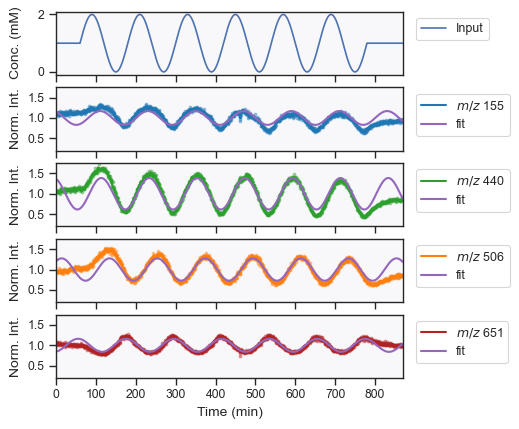

In [7]:
fig, ax = plt.subplots(5, 1, figsize=(7.3, 3.7))

sns.lineplot(
    data=profile, x=profile.index, y="Aldehyde_conc_rel", ax=ax[0], label="Input"
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="155_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[1],
    c="tab:blue",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="155_TIC_rel",
    ax=ax[1],
    linewidth=1.5,
    label=r"$\it{m/z}$ 155",
    c="tab:blue",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="440_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[2],
    c="tab:green",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="440_TIC_rel",
    ax=ax[2],
    linewidth=1.5,
    label=r"$\it{m/z}$ 440",
    c="tab:green",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="506_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[3],
    c="tab:orange",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="506_TIC_rel",
    ax=ax[3],
    linewidth=1.5,
    label=r"$\it{m/z}$ 506",
    c="tab:orange",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="651_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[4],
    c="firebrick",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="651_TIC_rel",
    ax=ax[4],
    linewidth=1.5,
    label=r"$\it{m/z}$ 651",
    c="firebrick",
)

ax[0].set_xlim(0, 870)
ax[1].set_xlim(0, 870)
ax[2].set_xlim(0, 870)
ax[3].set_xlim(0, 870)
ax[4].set_xlim(0, 870)
ax[1].set_ylim(0.2, 1.75)
ax[2].set_ylim(0.2, 1.75)
ax[3].set_ylim(0.2, 1.75)
ax[4].set_ylim(0.2, 1.75)

ax[0].set_ylabel("Conc. (mM)", fontsize=10)
ax[1].set_ylabel("Norm. Int.", fontsize=10)
ax[2].set_ylabel("Norm. Int.", fontsize=10)
ax[3].set_ylabel("Norm. Int.", fontsize=10)
ax[4].set_ylabel("Norm. Int.", fontsize=10)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[3].set_xlabel("")
ax[4].set_xlabel("Time (min)", fontsize=10)

ax[0].set_xticklabels("")
ax[1].set_xticklabels("")
ax[2].set_xticklabels("")
ax[3].set_xticklabels("")


fit_155 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["155_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_440 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["440_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_506 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["506_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_651 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["651_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time

pred_155 = sinfunc(data_2ndosci.index.to_numpy(), fit_155[4], 60, fit_155[3], 1)
pred_440 = sinfunc(data_2ndosci.index.to_numpy(), fit_440[4], 60, fit_440[3], 1)
pred_506 = sinfunc(data_2ndosci.index.to_numpy(), fit_506[4], 60, fit_506[3], 1)
pred_651 = sinfunc(data_2ndosci.index.to_numpy(), fit_651[4], 60, fit_651[3], 1)

# Uncomment to plot the fitted sinewaves
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_155,
    ax=ax[1],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_440,
    ax=ax[2],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_506,
    ax=ax[3],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_651,
    ax=ax[4],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)

ax[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[2].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[3].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[4].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)

ax[0].set_facecolor("#F8F8FB")
ax[1].set_facecolor("#F8F8FB")
ax[2].set_facecolor("#F8F8FB")
ax[3].set_facecolor("#F8F8FB")
ax[4].set_facecolor("#F8F8FB")

print("155", fit_155[0:3])
print("440", fit_440[0:3])
print("506", fit_506[0:3])
print("651", fit_651[0:3])

fig.align_ylabels(ax[:])

plt.subplots_adjust(left=None, bottom=None, right=0.6, top=1.1, wspace=None, hspace=0.2)
# plt.savefig('Figure2_int_fit.svg', format='svg', bbox_inches='tight', dpi=600)

In [8]:
# Read MS data

msdata = pd.read_csv("data/MS.xy", sep="\t", names=["mz", "int"])
MS155 = pd.read_csv("data/mz155.xy", sep="\t", names=["mz", "int"])
MS326 = pd.read_csv("data/mz326.xy", sep="\t", names=["mz", "int"])
MS440 = pd.read_csv("data/mz440.xy", sep="\t", names=["mz", "int"])
MS506 = pd.read_csv("data/mz506.xy", sep="\t", names=["mz", "int"])
MS651 = pd.read_csv("data/mz651.xy", sep="\t", names=["mz", "int"])

Text(0, 0.5, 'Relative ESI-MS intensity')

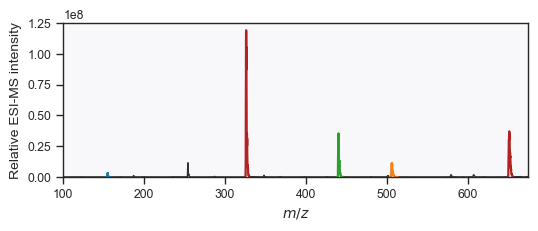

In [9]:
fig, ax = plt.subplots(figsize=(6, 2))
sns.lineplot(msdata, x="mz", y="int", c="black", alpha=0.8, linewidth=1)
sns.lineplot(MS155, x="mz", y="int", c="tab:blue", linewidth=1.5)
sns.lineplot(MS440, x="mz", y="int", c="tab:green", linewidth=1.5)
sns.lineplot(MS326, x="mz", y="int", c="firebrick", linewidth=1.5)
sns.lineplot(MS506, x="mz", y="int", c="tab:orange", linewidth=1.5)
sns.lineplot(MS651, x="mz", y="int", c="firebrick", linewidth=1.5)


ax.set_xlim(100, 675)
ax.set_ylim(bottom=0)

ax.set_facecolor("#F8F8FB")
ax.set_xlabel(r"$\it{m/z}$", fontsize=10)
ax.set_ylabel("Relative ESI-MS intensity", fontsize=10)
# plt.savefig('Figure2_MS.svg', format='svg', bbox_inches='tight', dpi=600)

In [10]:
# Read delays data

data = pd.read_excel("data/Hammett_delays.xlsx")
print(data)

  Substituent  Hammett_param  Delay_1-3  Delay_1-5
0   p-N(CH3)2          -0.83      13.01      13.46
1       p-OMe          -0.27      -4.10      18.69
2         p-H           0.00       2.86      23.44
3        p-Cl           0.23       1.56      29.31
4       p-NO2           0.78       5.18      31.05


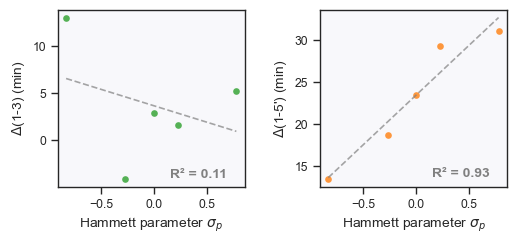

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(5.8, 2.3))

x = data["Hammett_param"].values
y1 = data["Delay_1-3"].values
y2 = data["Delay_1-5"].values

x = x.reshape(len(x), 1)
y1 = y1.reshape(len(y1), 1)
y2 = y2.reshape(len(y2), 1)

regr1 = linear_model.LinearRegression(fit_intercept=True)
regr1.fit(x, y1)

regr2 = linear_model.LinearRegression(fit_intercept=True)
regr2.fit(x, y2)

ax[0].plot(x, regr1.predict(x), c="grey", alpha=0.7, linestyle="--")
ax[1].plot(x, regr2.predict(x), c="grey", alpha=0.7, linestyle="--")

sns.scatterplot(
    data,
    x="Hammett_param",
    y="Delay_1-3",
    c="tab:green",
    ax=ax[0],
    alpha=0.8,
    linewidth=0,
)
sns.scatterplot(
    data,
    x="Hammett_param",
    y="Delay_1-5",
    c="tab:orange",
    ax=ax[1],
    alpha=0.8,
    linewidth=0,
)

ax[0].set_facecolor("#F8F8FB")
ax[0].set_xlabel(r"Hammett parameter $\sigma_{p}$", fontsize=10)
ax[0].set_ylabel(r"$\Delta$(1-3) (min)", fontsize=10)
ax[1].set_facecolor("#F8F8FB")
ax[1].set_xlabel(r"Hammett parameter $\sigma_{p}$", fontsize=10)
ax[1].set_ylabel(r"$\Delta$(1-5') (min)", fontsize=10)

ax[0].text(
    0.15, -4, f"R² = {regr1.score(x,y1).round(2)}", fontsize=10, c="grey", weight="bold"
)
ax[1].text(
    0.15,
    13.65,
    f"R² = {regr2.score(x,y2).round(2)}",
    fontsize=10,
    c="grey",
    weight="bold",
)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None
)
# plt.savefig('Figure2_Hammett.svg', format='svg', bbox_inches='tight', dpi=600)